# MAPD-B-Gr10 Project: Distributed Algorithms - K-means
by Erica Brisigotti (2097202), Ekaterina Chueva (2072050), Sofia Pacheco Garcia (2070771), Nadillia Sahputra (2070770)

# Starting the SparkSession

In [1]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import pyspark.pandas as ps


from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import avg
from pyspark.sql.functions import count
from operator import add
from pyspark.sql.functions import stddev_samp
import sklearn
import numpy as np
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import Row
from sklearn.datasets import fetch_kddcup99
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
import time
show = True

In [2]:
spark = SparkSession.builder \
    .master("spark://10.67.22.70:7077")\
    .appName("MAPD_B_project")\
    .config("spark.executor.memory", "1g")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
    .config('spark.default.parallelism','12')\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/07/11 16:37:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from py4j.java_gateway import java_import
java_import(spark._sc._jvm, "org.apache.spark.sql.api.python.*")

In [4]:
spark

In [5]:
# create a spark context
sc = spark.sparkContext

# print its status
sc

<SparkContext master=spark://10.67.22.70:7077 appName=MAPD_B_project>

In [6]:
scc = spark._jsc.sc() 
n_workers =  len([executor.host() for executor in scc.statusTracker().getExecutorInfos() ]) -1

print(n_workers)

3


# Importing and preprocessing Kddcup99 dataset

In [7]:
data0 = fetch_kddcup99(percent10=True, as_frame=True)

From the Sklearn dataset, we take the data (consisting of 42 columns and around 500000 rows) and the corresponding targets which specify the classes in which the rows should be classified.

K-means algorithms perform best when provided with comparable size classes. Therefore, we keep only
the classes with the most data (>10000 occurences). We implement this by selecting based on the target.

In [8]:
#Examine labels 
tdf = pd.DataFrame(data0.target)
#Count every unique values
df_label = pd.DataFrame({'labels':(tdf.groupby('labels').size()).keys() , 'counts': 
                         (tdf.groupby('labels').size()).values})
#Sorting from most to least frequent
df_label = df_label.sort_values(by = 'counts', ascending = False)

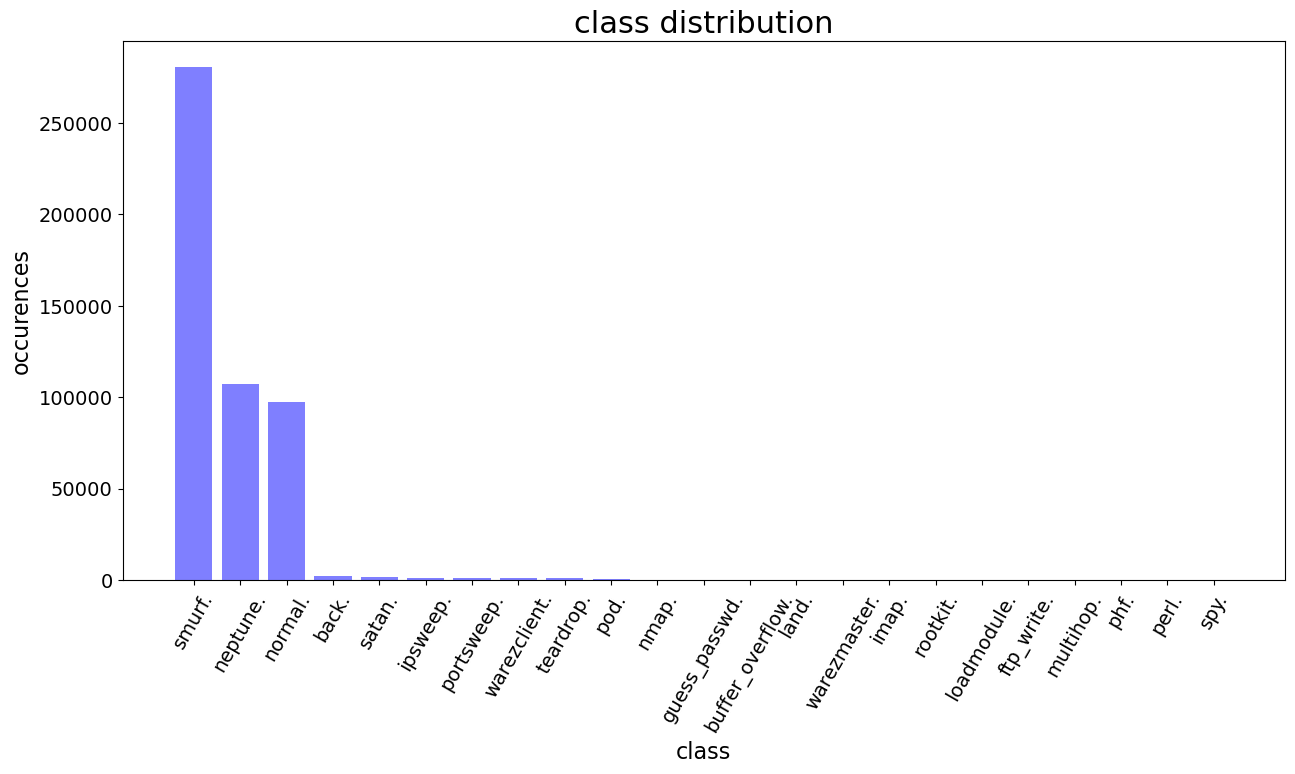

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.bar(df_label['labels'], df_label['counts'], color ='blue', alpha=0.5)
plt.title('class distribution', fontsize = 22)
plt.xlabel('class',fontsize = 16)
plt.ylabel('occurences',fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(rotation=60, fontsize = 14)
plt.show()

In [10]:
#Keep only the label with comparable frequency (more than 10.000) 
df_tokeep = df_label[df_label['counts']>10000]

#Keeping the rows correspond to the chosen label
blue = df_tokeep['labels'].to_numpy()
data0.data['target'] = data0.target
non_dist = data0.data
non_dist = non_dist.loc[non_dist['target'].isin(blue)]

#Ensuring only the chosen label appear 
non_dist.groupby('target').size().sort_values(ascending=False)

# non_dist_dist = data0.data[0:500]
df = spark.createDataFrame(non_dist)

We are left with 3 classes, of around 100000 elements each.

We only want to keep the numeric columns and, out of those, we do not want to store the columns of the dataset which values do not change.

In [11]:
# we list all columns
cols = list(non_dist.columns.values)

# we select the non-numeric columns, that we need to treat differently
non_numeric = ['protocol_type','service','flag']
for c in non_numeric:
    cols.remove(c)   

std_per_col = non_dist[cols].std().values
b = np.where([std_per_col > 10**(-16) ])[1]
cols_to_save = [cols[n] for n in b]
print('the number of columns saved is',len(cols_to_save),' out of ',len(non_dist.columns.values))

the number of columns saved is 35  out of  42


In [12]:
non_dist = non_dist[cols_to_save]
non_dist = non_dist[0:35000]

In [13]:
df = spark.createDataFrame(non_dist)
s = df.count()
cols = df.columns

23/07/11 16:37:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [14]:
dist_cols = sc.parallelize(cols)

for_zscore = np.zeros((len(cols),2))
#  for each column to standardize
for j,c in enumerate(cols):
    for_zscore[j,0] =  np.mean(non_dist[c])
    for_zscore[j,1] =  np.std(non_dist[c])

# since we are going to divide by the standard deviation, we need to make sure it's never 0
pos = np.where([el == (0.0,0.0) for el in for_zscore])[0]
# if the standard deviation of a column is ever 0, the column has always the same value (equal to its mean)
# therefore, we substitue the 0s with 1s
for el in pos:
    for_zscore[int(el)] = (0,1)
#  we finally standardize
for c, (mean, std_dev) in zip(cols, for_zscore):
    # Compute z-score for each row in the column
    df = df.withColumn(c, (col(c) - mean) / std_dev)

# Algorithms

The following section focuses on implementing the k-means algorithms for $k=3$: k-means||, k-means++ and naive k-means.

For k-means|| we find the optimal parameters by analizing the trend of the cost per number of iteration.


# K-means||

For a subset $Y \subseteq X$ of points, let its centroid be given by

$$
\operatorname{centroid}(Y)=\frac{1}{|Y|} \sum_{y \in Y} y
$$

Let $\mathcal{C}=\left\{c_1, \ldots, c_k\right\}$ be a set of points and let $Y \subseteq X$. We define the cost of $Y$ with respect to $\mathcal{C}$ as

$$
\phi_Y(\mathcal{C})=\sum_{y \in Y} d^2(y, \mathcal{C})=\sum_{y \in Y} \min _{i=1, \ldots, k}\left\|y-c_i\right\|^2 .
$$

The goal of $k$-means clustering is to choose a set $\mathcal{C}$ of $k$ centers to minimize $\phi_X(\mathcal{C})$.

In [15]:
# this is the procedure that we will apply to each line of the dataframe later with map
def my_distance(x, centroids):
    # we initialize the input to 0
    dist = np.zeros(len(centroids))
    for i in range(len(centroids)):
        # we loop over all columns of the dataframe (except target)
        for c in cols:
            dist[i] += (x[c] - centroids[i][c])**2
    # we select the minimum value of distance, meaning that we associate the point to the cluster that returns the least cost
    min_dist = np.min(dist)
    index_min = np.argmin(dist)
    return min_dist, index_min

In the function below we follow the steps from the paper in order to initialize K-means|| algorithm:

\\begin{aligned}
& \hline \text { Algorithm } 2 k \text {-means } \|(k, \ell) \text { initialization. } \\
& \hline \text { 1: } \mathcal{C} \leftarrow \text { sample a point uniformly at random from } X \\
& \text { 2: } \psi \leftarrow \phi_X(\mathcal{C}) \\
& \text { 3: for } O(\log \psi) \text { times do } \\
& \text { 4: } \quad \mathcal{C}^{\prime} \leftarrow \text { sample each point } x \in X \text { independently with } \\
& \quad \text { probability } p_x=\frac{\ell \cdot d^2(x, \mathcal{C})}{\phi_X(\mathcal{C})} \\
& \text { 5: } \quad \mathcal{C} \leftarrow \mathcal{C} \cup \mathcal{C}^{\prime} \\
& \text { 6: end for } \\
& \text { 7: For } x \in \mathcal{C} \text {, set } w_x \text { to be the number of points in } X \text { closer } \\
& \quad \text { to } x \text { than any other point in } \mathcal{C} \\
& \text { 8: Recluster the weighted points in } \mathcal{C} \text { into } k \text { clusters }
\end{aligned}

In [16]:
def k_means_parallel_init(k, df, l, n_iterations=5, show=False):
    np.random.seed(55555)
    # STEP 1: we randomly extract  a centroid to start with from a uniform distribution 
    s = df.count()
    rn = np.random.randint(0,s)
    centroids = [df.collect()[rn]]
    if show: print('the number of centroids is',len(centroids))
    
    # STEP 2: we compute the initial cost from just one centroid
    cost = df.rdd.map(lambda x: my_distance(x, centroids)[0]) \
                         .reduce(lambda a,b: a+b) # .reduce(sum) wasn't working even though they're supposed to be identical
    cost_record = [cost]
    n_centroids = [1]

    if show: 
        print('the number of centroids is',len(centroids))
        print('cost at step 0 : ', cost)

    # STEPS 3-4-5-6:
    # for every iteration
    for i in range(n_iterations):

        # Since probability Px depends on the distance of x and C, we store the distance together with the data for later use. 
        forlater = df.rdd \
                     .map(lambda x: (my_distance(x, centroids)[0], x)) \
                     .persist()

        # we re-compute the cost (after adding, at the end of the previous iteration, new centroids)
        if i!=0:
            cost = df.rdd\
                     .map(lambda x: my_distance(x, centroids)[0]) \
                     .reduce(lambda a,b: a+b) 
            cost_record.append(cost)
            if show: print('cost at step '+str(i), ' : ', cost) 

        # we select the new centroids (while storing their info)
        new_centroid_info = forlater \
                            .map(lambda x: (True, x[1]) if np.random.uniform(size = 1) < l*x[0]/cost else (False, x[1])) \
                            .filter(lambda x: x[0]) \
                            .collect() # return a list with a variable number of tuples
        
        # we save the newly found centroids
        new_centroid_row = [row[1] for row in new_centroid_info]
        centroids += new_centroid_row  
        n_centroids.append(len(centroids))
        if show: 
            print('the number of centroids is',len(centroids))
        # we free up memory
        forlater.unpersist()

    # STEP 7
    # we compute the weights of each cluster 
    point_centroid_pairs = df.rdd\
                             .map(lambda point: ((my_distance(point, centroids)[1]) , 1 ) )\
                             .reduceByKey(add)\
                             .collect()
    # and sort it
    point_centroid_pairs.sort(key=lambda a: a[1], reverse = True)

    # STEP 8: we reduce to k centroids (the ones with heavier weights)
    dist_centroids = sc.parallelize(point_centroid_pairs)
    idx_for_later = dist_centroids.map(lambda x: x[0])\
                                    .collect()[:k]

    lloyd_centroids = [centroids[i] for i in idx_for_later]

    return cost_record, n_centroids, lloyd_centroids

$$
\begin{aligned}
& \text { Algorithm } \text { Lloyd } \\
& \text { 1: calculate the centroids as mean of their assigned points } \\
& \text { 2: repeat } \\
& \text { 3: reassign each datapoint to its closest centroid } \\
& \text { 4: recalculate centroids as mean over their assigned datapoints } \\
& \text { 5: until convergence }
\end{aligned}
$$

In [17]:
def Lloyd(df, k, centroids, max_iters=50, degree=-3, plot = False):
    cost_record = []
    for ll in range(max_iters):
        the_group = df.rdd.map(lambda x: (my_distance(x, centroids)[1], list(x)))

        new_centroids = the_group.groupByKey()\
                       .mapValues(lambda vals: [np.mean(list(val)) for val in zip(*vals)]) \
                       .collect()
        new_centroids.sort()
        new_centroids = [x[1] for x in new_centroids]


        new_centroids = [Row(**dict(zip(cols, x))) for x in new_centroids]

        
        # we compute and save the cost for the newly found centroids
        cost = df.rdd\
                 .map(lambda x: my_distance(x, new_centroids)[0]) \
                 .reduce(lambda a,b: a+b) 
        
        cost_record.append(cost)
        
        # when we converge
        if ll>1 and abs(cost_record[-2]-cost_record[-1])<(10**(degree)):     #new_centroids == centroids:
            # we return the results of the classification
            the_group = df.rdd.map(lambda x: (my_distance(x, centroids)[1], list(x)))
            break
        # otherwise, we just update the centroids for the next round
        centroids = new_centroids
        
        
    
    # we warn the user that we stopped artificially
    if ll==(max_iters-1):
        print('we did all max_iter iterations')
    # and still return the results of the classification
    the_group = df.rdd.map(lambda x: (my_distance(x, centroids)[1], list(x)))
            
    print(cost_record) 
    if plot: 
        return the_group, centroids, cost_record
    else: 
        return the_group, centroids

We combine the initialization for K-means|| with the Lloyd's algorithm into a single function.

In [18]:
def K_parallel(df, k, l, n_it_init, n_it_lloyd, show=False, plot=True, saving=False, gridsearch = ''):
    '''
    function that applies the K parallel algorithm by first doing the characteristic parallel 
    initialization and applying Lloyd´s algorithm. 
    The inputs are
    - df: the dataframe which rows are to be classified
    - k: the number of clusters
    - l: the parameter necessary for the initialization (see k_means_parallel_init)
    - n_it_init: the number of iterations that are done in the initialization 
    - n_it_lloyd: the maximum number of iterations that are done in Lloyd's algorithm
    - show: the display option for the initialization part (see k_means_parallel_init)
    - plot: the option to return the variables for plotting for Lloyd's algorithm
    - saving: an option to save the entire output (only with also plot=True)
    '''
    
    t0 = time.time()
    
    init_cost, n_centroids, lloyds_centroids = k_means_parallel_init(k, df, l, n_it_init, show=show)
    
    t_init = time.time() - t0
    
    if plot:
        
        the_group, new_centroids, lloyd_cost = Lloyd(df, k, lloyds_centroids, n_it_lloyd, plot=plot)
        
        # we save the results of the iterations in a dataframe, distinguishing them between 
        # initialization and lloyd's algorithm
        if saving:
            init_iteration = list(range(len(init_cost)))
            init_id = ['initialization']*len(init_cost)
            lloyd_iteration = list(range(len(lloyd_cost)))
            lloyd_id = ['lloyd']*len(lloyd_cost)
            plot_dataframe = pd.DataFrame({ 'iterations':  list(range( len(init_cost) + len(lloyd_cost))), 
                                           'cost': init_cost+lloyd_cost, 'id': init_id+lloyd_id  })
            plot_dataframe.to_csv(gridsearch+'kll_k'+str(k)+'_l'+str(l)+'_ii'+str(n_it_init)+'_il'+str(n_it_lloyd)+'.csv')
        t_lloyd = time.time() - t_init -t0
        return the_group, new_centroids, n_centroids, lloyd_cost, init_cost, t_init, t_lloyd
        
    else:
        the_group, new_centroids = Lloyd(df, k, lloyds_centroids, n_it_lloyd, plot)
        t_lloyd = time.time() - t_init -t0
        return the_group, new_centroids, n_centroids, t_init, t_lloyd  

In [19]:
file_save = False    
if file_save:
    # we also save the time info 
    df_info_l = pd.DataFrame({ 'k' : [], 'l': [], 'n_it_init': [], 'n_it_lloyd': [], 't_init': [], 't_lloyd': [], 't_total': []  })

    ls =[5, 10,15]
    Ks = [3]
    n_it_inits =[20]
    n_it_lloyds =[40]

    file_names = []
    for l in ls:
        for K in Ks:
            for n_it_init in n_it_inits:
                for n_it_lloyd in n_it_lloyds:
                    np.random.seed(55555)
                    the_group, centroids_par, n_centroids_par, cost_par, cost_par_init, t_init, t_lloyd = K_parallel(df, K, l, 
                                                            n_it_init, n_it_lloyd, show=False, plot=True, saving=True, gridsearch = 'l_grid_search_')

                    new_row = pd.DataFrame({'k': [K], 'l': [l], 'n_it_init': [n_it_init], 'n_it_lloyd': [n_it_lloyd], 
                                            't_init': [t_init],'t_lloyd': [t_lloyd], 't_total' :[t_init+t_lloyd]})
                    df_info_l = pd.concat([df_info_l, new_row], ignore_index=True)   
                    file_names = file_names + [ 'l_grid_search_'+'kll_k'+str(K)+'_l'+str(l)+'_ii'+str(n_it_init)+'_il'+str(n_it_lloyd)+'.csv']

    df_info_l.to_csv('df_info_l.csv')

Here we plot all the results obtained for values of l. 

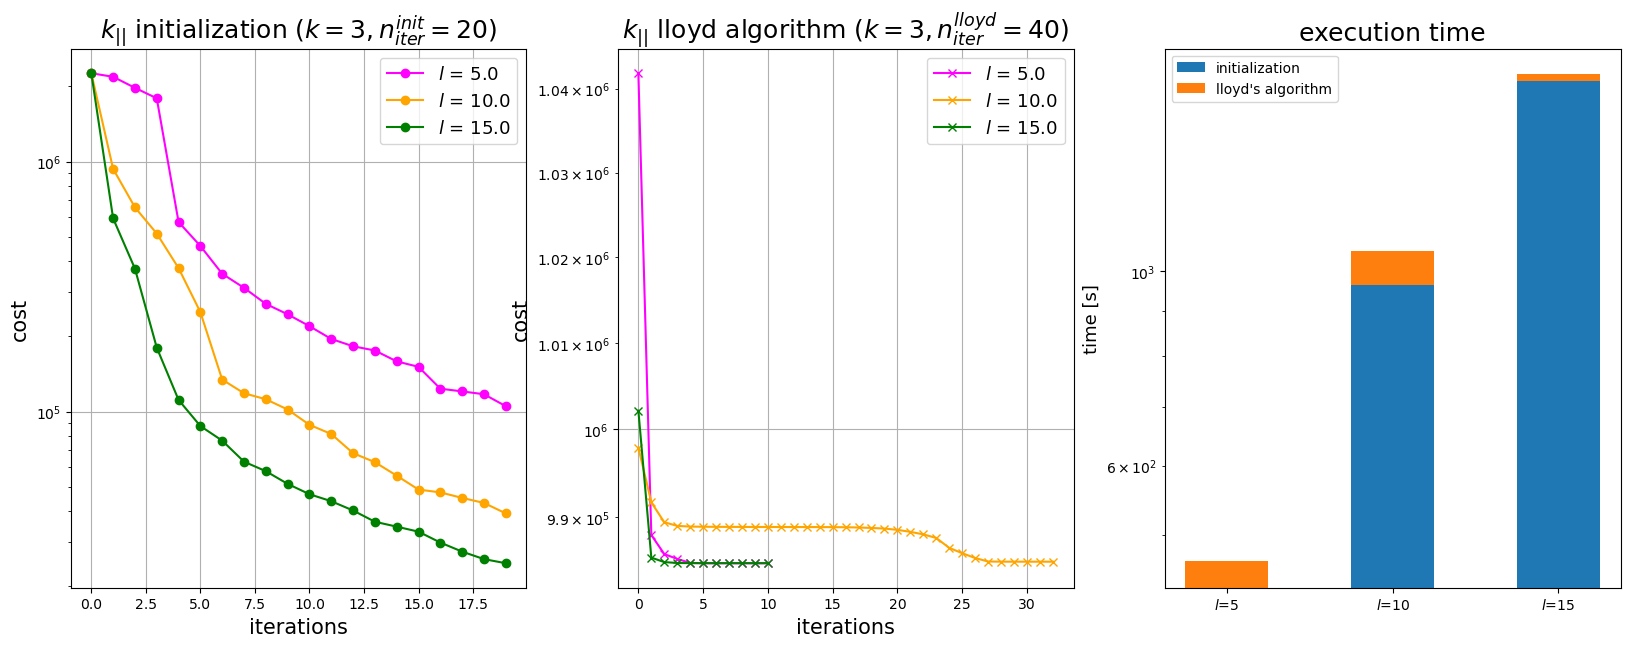

In [20]:
df_info_l = pd.read_csv('df_info_l.csv')


file_names = []
for r in range(len(df_info_l)):
    K = df_info_l['k'][r]
    l = df_info_l['l'][r]
    n_it_init = df_info_l['n_it_init'][r]
    n_it_lloyd = df_info_l['n_it_lloyd'][r]
    file_names = file_names + [ 'l_grid_search_'+'kll_k'+str(int(K))+'_l'+str(int(l))+'_ii'+str(int(n_it_init))+'_il'+str(int(n_it_lloyd))+'.csv']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
option_names = []
ls = df_info_l['l']
for l in ls:
    option_names = option_names + ['$l$ = '+str(l)]
title = ['initialization ($ k = 3, n_{iter}^{init} = 20 $)', 'lloyd algorithm ($ k = 3, n_{iter}^{lloyd} = 40 $)']
c = ['magenta', 'orange', 'green', 'navy', 'red', 'purple', 'lime' ]
method = '$k_{||}$ '

temp = df_info_l['n_it_init']
for i, name in enumerate(file_names):
    # I upload the data
    blabla = pd.read_csv(name)
    # initialization plot
    init_x = blabla['iterations'][blabla['id']=='initialization'] 
    init_y = blabla['cost'][blabla['id']=='initialization']
    ax[0].plot(init_x, init_y, c=c[i], marker ='o', label=option_names[i])
    # Lloyd's iteration plot
    lloyd_x = blabla['iterations'][blabla['id']=='lloyd'] - temp[i]
    lloyd_y = blabla['cost'][blabla['id']=='lloyd']
    ax[1].plot(lloyd_x, lloyd_y, c=c[i], marker='x', label=option_names[i])
    

for r in range(2):
    ax[r].set_xlabel('iterations', fontsize=15)
    ax[r].set_ylabel('cost', fontsize=15)
    ax[r].set_yscale('log')
    ax[r].set_title(method+title[r], fontsize=18)
    ax[r].legend(loc = 'upper right', fontsize=13)
    ax[r].grid('minor')
    
    
temp = [int(el) for el in df_info_l['l']] 
species = ['$l$='+str(int(t)) for t in temp]
weight_counts = {
    "initialization": df_info_l['t_init'].to_numpy(),
    "lloyd's algorithm": df_info_l['t_lloyd'].to_numpy(),
}
width = 0.5
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    ax[2].bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax[2].set_title("execution time", fontsize=18)
ax[2].set_ylabel('time [s]',fontsize=13)
ax[2].legend(loc="upper left")
ax[2].set_yscale('log')

plt.show()

We notice that the performance of $l=5$ and $l=15$ is equivalent, while the execution time  increases with $l$. Therefore, we choose to proceed with $l=5$.

Now we do a gridsearch for the number of iterations in the initialization.

In [21]:
if file_save:
    # we also save the time info 
    df_info_k = pd.DataFrame({ 'k' : [], 'l': [], 'n_it_init': [], 'n_it_lloyd': [], 't_init': [], 't_lloyd': [], 't_total': []  })

    ls =[5]
    Ks = [3]
    n_it_inits =[10, 20, 30]
    n_it_lloyds =[40]

    file_names = []
    for l in ls:
        for K in Ks:
            for n_it_init in n_it_inits:
                for n_it_lloyd in n_it_lloyds:
                    np.random.seed(55555)
                    the_group, centroids_par, n_centroids_par, cost_par, cost_par_init, t_init, t_lloyd = K_parallel(df, K, l, 
                                    n_it_init, n_it_lloyd, show=False, plot=True, saving=True, gridsearch = 'n_grid_search_')

                    new_row = pd.DataFrame({'k': [K], 'l': [l], 'n_it_init': [n_it_init], 'n_it_lloyd': [n_it_lloyd], 
                                            't_init': [t_init],'t_lloyd': [t_lloyd], 't_total' :[t_init+t_lloyd]})
                    df_info_k = pd.concat([df_info_k, new_row], ignore_index=True)   
                    file_names = file_names + [ 'n_grid_search_'+'kll_k'+str(K)+'_l'+str(l)+'_ii'+str(n_it_init)+'_il'+str(n_it_lloyd)+'.csv']

    df_info_k.to_csv('df_info_k.csv')

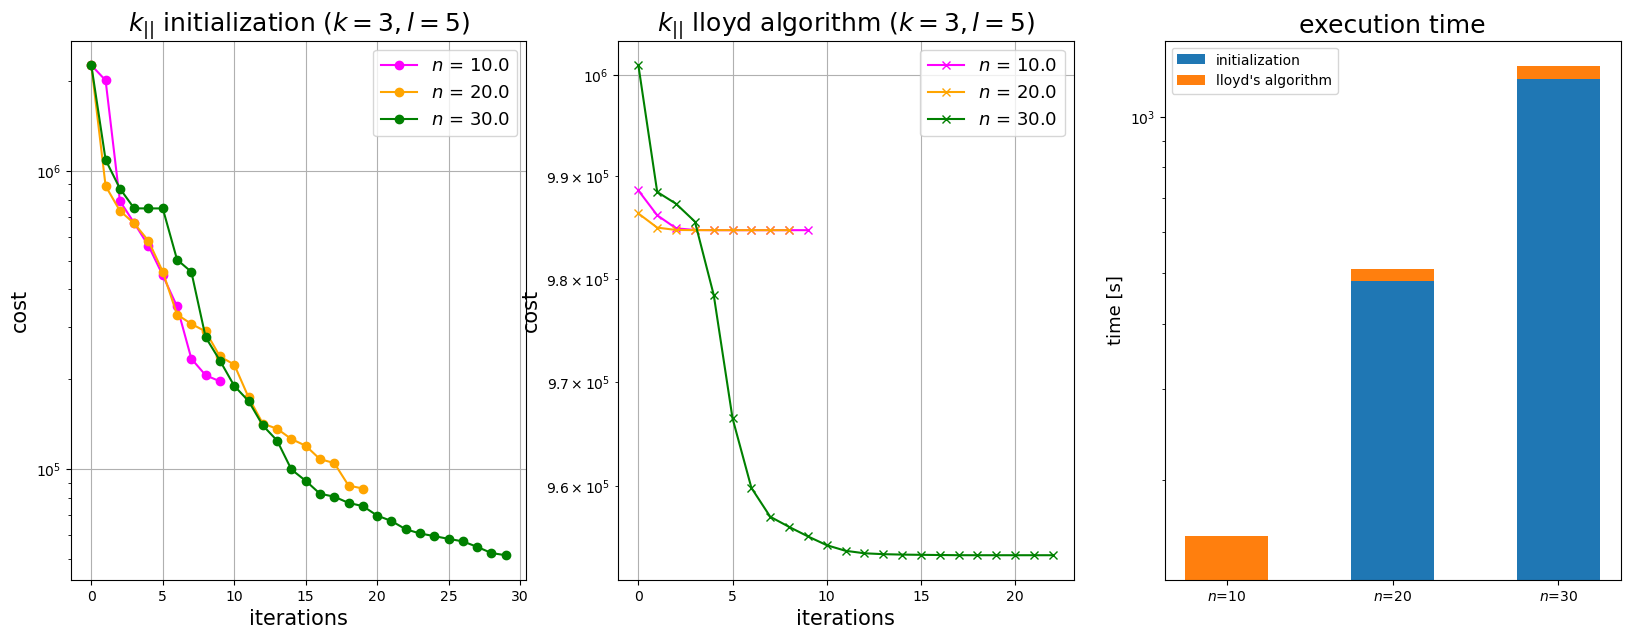

In [22]:
df_info_k = pd.read_csv('df_info_k.csv')

file_names = []
for r in range(len(df_info_k)):
    K = df_info_k['k'][r]
    l = df_info_k['l'][r]
    n_it_init = df_info_k['n_it_init'][r]
    n_it_lloyd = df_info_k['n_it_lloyd'][r]
    file_names = file_names + ['n_grid_search_'+'kll_k'+str(int(K))+'_l'+str(int(l))+'_ii'+str(int(n_it_init))+'_il'+str(int(n_it_lloyd))+'.csv']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
option_names = []
n = df_info_k['n_it_init']
for l in n:
    option_names = option_names + ['$n$ = '+str(l)]
title = ['initialization ($ k = 3, l = 5 $)', 'lloyd algorithm ($ k = 3, l = 5 $)']
c = ['magenta', 'orange', 'green', 'navy', 'red', 'purple', 'lime' ]
method = '$k_{||}$ '

temp = df_info_k['n_it_init']
for i, name in enumerate(file_names):
    # I upload the data
    blabla = pd.read_csv(name)
    # initialization plot
    init_x = blabla['iterations'][blabla['id']=='initialization'] 
    init_y = blabla['cost'][blabla['id']=='initialization']
    ax[0].plot(init_x, init_y, c=c[i], marker ='o', label=option_names[i])
    # Lloyd's iteration plot
    lloyd_x = blabla['iterations'][blabla['id']=='lloyd'] - temp[i]
    lloyd_y = blabla['cost'][blabla['id']=='lloyd']
    ax[1].plot(lloyd_x, lloyd_y, c=c[i], marker='x', label=option_names[i])
    

for r in range(2):
    ax[r].set_xlabel('iterations', fontsize=15)
    ax[r].set_ylabel('cost', fontsize=15)
    ax[r].set_yscale('log')
    ax[r].set_title(method+title[r], fontsize=18)
    ax[r].legend(loc = 'upper right', fontsize=13)
    ax[r].grid('minor')
    
    
temp = [int(el) for el in df_info_k['n_it_init']] 
species = ['$n$='+str(int(t)) for t in temp]
weight_counts = {
    "initialization": df_info_k['t_init'].to_numpy(),
    "lloyd's algorithm": df_info_k['t_lloyd'].to_numpy(),
}
width = 0.5
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    ax[2].bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax[2].set_title("execution time", fontsize=18)
ax[2].set_ylabel('time [s]',fontsize=13)
ax[2].legend(loc="upper left")
ax[2].set_yscale('log')

plt.show()

We notice that the performance of $n=30$ is better than for the other values, despite having the longest execution time. Still, we have proceeded with $n=30$.

In [23]:
if file_save:
    df_info_k = pd.read_csv('df_info_k.csv')
    df_parall = pd.read_csv('n_grid_search_kll_k3_l5_ii30_il40.csv')

    t_init_parall = df_info_k['t_init'][0]
    t_lloyd_parall = df_info_k['t_lloyd'][0]

Whenever we dont want to gridsearch, we just run the K-parallel algorithm for the optimal parameters.

In [24]:
if not(file_save):    
    # we also save the time info 
    df_info_k = pd.DataFrame({ 'k' : [], 'l': [], 'n_it_init': [], 'n_it_lloyd': [], 't_init': [], 't_lloyd': [], 't_total': []  })

    ls =[10]
    Ks = [3]
    n_it_inits =[10]
    n_it_lloyds =[40]

    file_names = []
    for l in ls:
        for K in Ks:
            for n_it_init in n_it_inits:
                for n_it_lloyd in n_it_lloyds:
                    np.random.seed(55555)
                    the_group, centroids_par, n_centroids_par, cost_par, cost_par_init, t_init, t_lloyd = K_parallel(df, K, l, 
                                    n_it_init, n_it_lloyd, show=False, plot=True, saving=True, gridsearch = 'n_grid_search_')

                    new_row = pd.DataFrame({'k': [K], 'l': [l], 'n_it_init': [n_it_init], 'n_it_lloyd': [n_it_lloyd], 
                                            't_init': [t_init],'t_lloyd': [t_lloyd], 't_total' :[t_init+t_lloyd]})
                    df_info_k = pd.concat([df_info_k, new_row], ignore_index=True)   
                    file_names = file_names + [ 'n_grid_search_'+'kll_k'+str(K)+'_l'+str(l)+'_ii'+str(n_it_init)+'_il'+str(n_it_lloyd)+'.csv']
    
    t_init_parall = df_info_k['t_init'][0]
    t_lloyd_parall = df_info_k['t_lloyd'][0]

[1042415.6137182544, 987384.0912430056, 985657.6330477645, 985124.9167700086, 984740.6432276594, 984726.6414187609, 984726.2473916073, 984726.1601575166, 984726.1389469563, 984726.0767775185, 984726.0764658609]


In [25]:
df_parall = pd.read_csv('n_grid_search_kll_k3_l5_ii30_il40.csv')

## K-means++

$$
\begin{aligned}
& \hline \text { Algorithm  } k \text {-means}++(k) \text { initialization. } \\
& \hline 1: \mathcal{C} \leftarrow \text { sample a point uniformly at random from } X \\
& \text { 2: } \text { while }|\mathcal{C}|<k \text { do } \\
& \text { 3: } \quad \text { Sample } x \in X \text { with probability } \frac{d^2(x, \mathcal{C})}{\phi_X(\mathcal{C})} \\
& \text { 4: } \quad \mathcal{C} \leftarrow \mathcal{C} \cup\{x\} \\
& \text { 5: } \text { end while } \\
& \hline
\end{aligned}
$$

In the function below we provide the initialization for K-means++.

In [26]:
def k_means_plusplus_init(k, df, max_iter):
    
    # STEP 1: we randomly extract a centroid to start with from a uniform distribution 
    s = df.count()
    rn = np.random.randint(0, s)
    centroids = [df.collect()[rn]]
    cost_record = []
    n_centroids = [1]    
    i = 0
    
    # STEP 2-4: Iterate until we have k centroids
    while len(centroids) < k:
        
        if i >= max_iter: break
    
        #compute distances from points to centroids and sum all distances
        #since probability Px depends on the distance of x and C, we store the distance together with the data for later use. 
        forlater = df.rdd \
                     .map(lambda x: (my_distance(x, centroids)[0], x)) \
                     .persist()

        # we re-compute the cost (after adding, at the end of the previous iteration, new centroids)
        cost = df.rdd\
                 .map(lambda x: my_distance(x, centroids)[0]) \
                 .reduce(lambda a,b: a+b) 
        cost_record.append(cost)
        
        if show: print('cost at step '+str(i), ' : ', cost) 
        i = i+1       

        # we select the new centroids (while storing their info)
        new_centroid_info = forlater \
                            .map(lambda x: (True, x[1]) if np.random.uniform(size = 1) < x[0]/cost else (False, x[1])) \
                            .filter(lambda x: x[0]) \
                            .collect() # return a list with a variable number of tuples

        # we free up memory
        forlater.unpersist()
            
        # Add new centroid to list
        new_centroid_row = [row[1] for row in new_centroid_info]
        centroids += new_centroid_row  
        
        #record the number of centroids
        n_centroids.append(len(centroids))
    
    return cost_record, n_centroids, centroids

We combine now the initialization with the LLoyd's algorithm.

In [27]:
def K_plus_plus(df, k, n_it_lloyd, max_iter=20, show=False, plot=False):
    t0 = time.time()
    cost_record_init, n_centroids, lloyds_centroids = k_means_plusplus_init(k, df, max_iter)
    t_init = time.time()-t0
    if plot:
        the_group, new_centroids, cost_record = Lloyd(df, k, lloyds_centroids, n_it_lloyd, degree=-5, plot=plot)
        t_lloyd = time.time()-t_init-t0
        return the_group, new_centroids, n_centroids, cost_record, cost_record_init, t_init, t_lloyd
        
    else:
        
        the_group, new_centroids = Lloyd(df, k, lloyds_centroids, n_it_lloyd, plot)
        t_lloyd = time.time()-t_init-t0
        return the_group, new_centroids, n_centroids, t_init, t_lloyd

In [28]:
K = 3
n_it_lloyd = 40
plot = True #for final plot with comparison of algorithms

if plot:
    the_group, centroids_plpl, n_centroids_plpl, cost_plpl, cost_plpl_init, t_init_plpl, t_lloyd_plpl = K_plus_plus(df, K, n_it_lloyd, plot=plot)
else:
    the_group, centroids_plpl, n_centroids_plpl, t_init_plpl, t_lloyd_plpl = K_plus_plus(df_numeric, K, n_it_lloyd, plot=plot)

cost at step 0  :  1216820.7154756584


[1049096.4428944862, 1045481.0705585221, 1045370.7494944439, 1044650.2788119761, 1042121.439082607, 1041940.1074443692, 1041760.2465323601, 1041760.2465323601]


In [29]:
init_iteration = list(range(len(cost_plpl_init)))
init_id = ['initialization']*len(cost_plpl_init)
lloyd_iteration = list(range(len(cost_plpl)))
lloyd_id = ['lloyd']*len(cost_plpl)
df_plpl = pd.DataFrame({ 'iterations':  list(range( len(cost_plpl_init) + len(cost_plpl))), 
                               'cost': cost_plpl_init+cost_plpl, 'id': init_id+lloyd_id  })

## Naive K-means

In [30]:
def k_means_naive_init(k, df):
    
    # we randomly extract a centroid to start with from a uniform distribution 
    s = df.count()
    centroids=[]
    for num in range(k):
        rn=np.random.randint(0, s)
        centroids.append(df.collect()[rn])

    cost_record = []
    n_centroids = [k]    
    i = 0
    
    cost = df.rdd\
                 .map(lambda x: my_distance(x, centroids)[0]) \
                 .reduce(lambda a,b: a+b) 

    cost_record.append(cost)

    return cost_record, n_centroids, centroids

In [31]:
def K_naive(df, k, n_it_lloyd, show=False, plot=False):
    t0 = time.time()
    cost_record_init, n_centroids, lloyds_centroids = k_means_naive_init(k, df)
    t_init = time.time()-t0
    if plot:
        the_group, new_centroids, cost_record = Lloyd(df, k, lloyds_centroids, n_it_lloyd, degree=-5, plot=plot)
        t_lloyd = time.time()-t_init-t0
        return the_group, new_centroids, n_centroids, cost_record, cost_record_init, t_init, t_lloyd
    else:
        the_group, new_centroids = Lloyd(df, k, lloyds_centroids, n_it_lloyd, plot)
        t_lloyd = time.time()-t_init-t0
        return the_group, new_centroids, n_centroids, t_init, t_lloyd

In [32]:
K = 3
n_it_lloyd = 40
plot = True #for final plot with comparison of algorithms

if plot:
    the_group, centroids_naive, n_centroids_naive, cost_naive, cost_naive_init, t_init_naive, t_lloyd_naive = K_naive(df, K, n_it_lloyd, plot=plot)
else:
    the_group, centroids_naive, n_centroids_naive, t_init_naive, t_lloyd_naive = K_naive(df_numeric, K, n_it_lloyd, plot=plot)

[960252.2107360837, 957367.8950262996, 956345.9879868815, 955451.6470158679, 954594.8293513592, 953967.3106199445, 953700.8668231338, 953589.4064678688, 953545.7812451741, 953520.6215562028, 953504.7795989893, 953489.6024469034, 953477.2989739557, 953475.8101765095, 953475.7015166675, 953475.7015166675]


In [33]:
init_iteration = list(range(len(cost_naive_init)))
init_id = ['initialization']*len(cost_naive_init)
lloyd_iteration = list(range(len(cost_naive)))
lloyd_id = ['lloyd']*len(cost_naive)
df_naive = pd.DataFrame({ 'iterations':  list(range( len(cost_naive_init) + len(cost_naive))), 
                               'cost': cost_naive_init+cost_naive, 'id': init_id+lloyd_id  })

# Comparison of the algorithms

We now compare the behavior of the 3 algorithms for $k=3$ and $n_{iter}^{lloyd} = 40$.

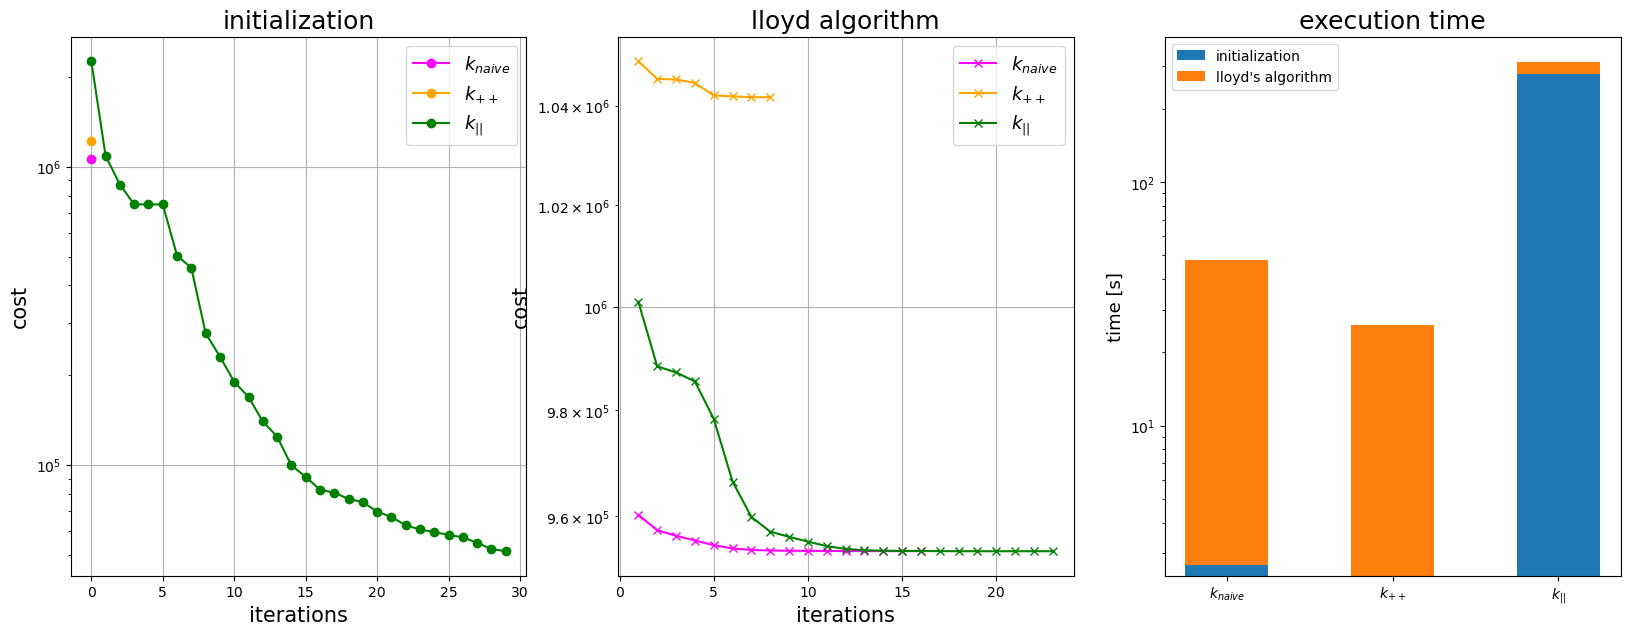

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

option_names = ['$k_{naive}$', '$k_{++}$', '$k_{||}$']
title = ['initialization', 'lloyd algorithm', 'execution time']
c = ['magenta', 'orange', 'green', 'navy', 'red', 'purple', 'lime' ]
method = ''

temp = [df_naive[df_naive['id'] == 'initialization' ]['iterations'].values[-1],
        df_plpl[df_plpl['id'] == 'initialization' ]['iterations'].values[-1],
        df_parall[df_parall['id'] == 'initialization' ]['iterations'].values[-1]]
dataframes = ['df_naive', 'df_plpl', 'df_parall']

for i, name in enumerate(dataframes):
    # I upload the data
    blabla = eval(name)
    # initialization plot
    init_x = blabla['iterations'][blabla['id']=='initialization'] 
    init_y = blabla['cost'][blabla['id']=='initialization']
    ax[0].plot(init_x, init_y, c=c[i], marker ='o', label=option_names[i])
    # Lloyd's iteration plot
    lloyd_x = blabla['iterations'][blabla['id']=='lloyd'] - temp[i]
    lloyd_y = blabla['cost'][blabla['id']=='lloyd']
    ax[1].plot(lloyd_x, lloyd_y, c=c[i], marker='x', label=option_names[i])
    

for r in range(2):
    ax[r].set_xlabel('iterations', fontsize=15)
    ax[r].set_ylabel('cost', fontsize=15)
    ax[r].set_yscale('log')
    ax[r].set_title(method+title[r], fontsize=18)
    ax[r].legend(loc = 'upper right', fontsize=13)
    ax[r].grid('minor')
    
    
temp = [int(el) for el in df_info_k['n_it_init']] 
species = option_names
weight_counts = {
    "initialization": [t_init_naive, t_init_plpl,t_init_parall],
    "lloyd's algorithm": [t_lloyd_naive, t_lloyd_plpl,t_lloyd_parall],
}
                       
width = 0.5
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    ax[2].bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax[2].set_title("execution time", fontsize=18)
ax[2].set_ylabel('time [s]',fontsize=13)
ax[2].legend(loc="upper left")
ax[2].set_yscale('log')

plt.show()

In [35]:
weight_counts = {
    "initialization": [t_init_naive, t_init_plpl,t_init_parall],
    "lloyd's algorithm": [t_lloyd_naive, t_lloyd_plpl,t_lloyd_parall],
}

In [36]:
core_df = pd.DataFrame(weight_counts)

In [37]:
core_df.to_csv('auto_partitions_12.csv')

# Evaluating the performance based on the number of partitions

Here we compare the results for the execution time obtained changing the number of partitions. To make our life easier, we pick numbers of partitions that are multiples of the number of workers.

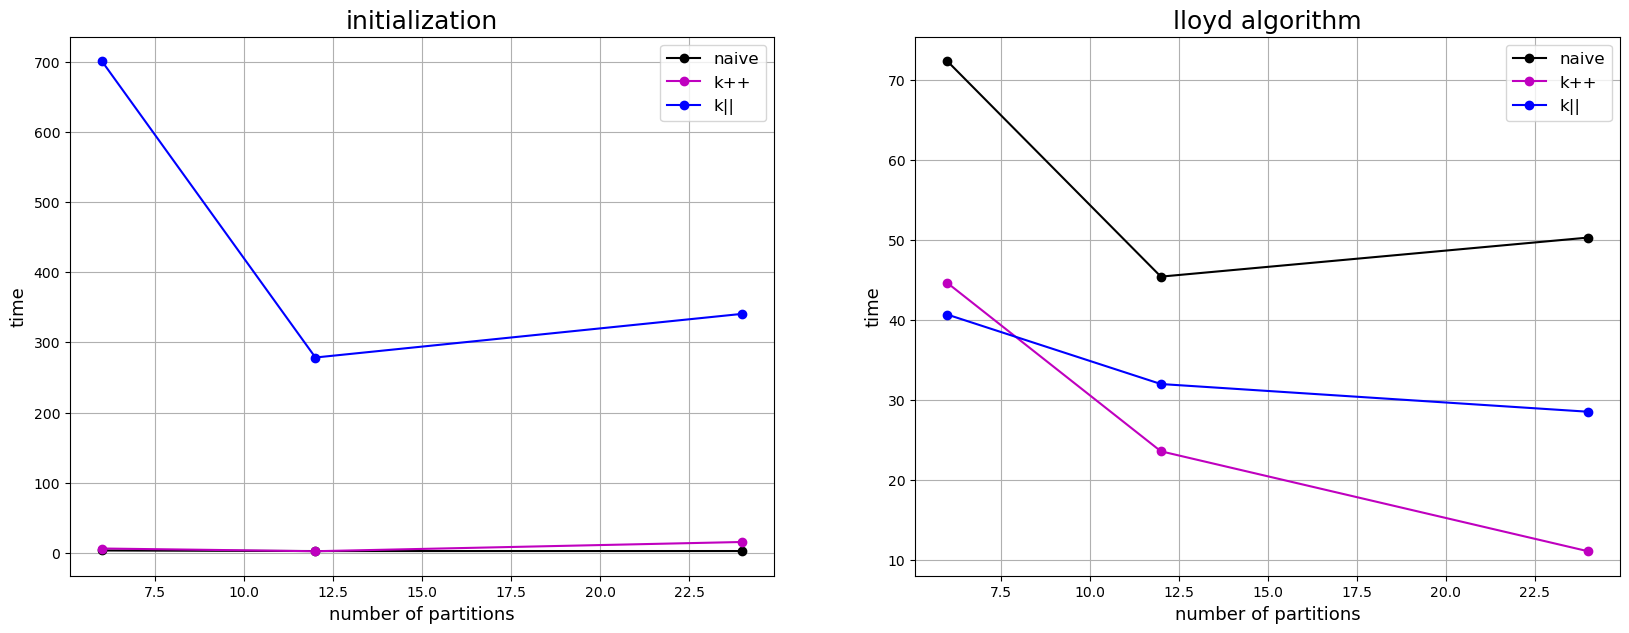

In [38]:
parallelization_values = ['6','12','24']
parallelization_names = ['auto_partitions_'+val for val in parallelization_values]

all_initialization = pd.DataFrame({'n_partitions': [],'naive': [],'plpl': [],'para': []})
all_lloyd = pd.DataFrame({'n_partitions': [],'naive': [],'plpl': [],'para': []})
naive = [0,0,0]
plpl = [0,0,0]
parall = [0,0,0]
naive2 = [0,0,0]
plpl2 = [0,0,0]
parall2 = [0,0,0]
    

for i in range(len(parallelization_values)):
    nad = parallelization_names[i]
    initial = eval("pd.read_csv('"+nad+".csv')")
    naive[i] = initial['initialization'][0]
    plpl[i] = initial['initialization'][1]
    parall[i] = initial['initialization'][2]
    naive2[i] = initial["lloyd's algorithm"][0]
    plpl2[i] = initial["lloyd's algorithm"][1]
    parall2[i] = initial["lloyd's algorithm"][2]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
title = ['initialization', 'lloyd algorithm']
x = [6,12,24]
ax[0].plot(x, naive, 'o-k', label='naive')
ax[0].plot(x, plpl,'o-m', label='k++')
ax[0].plot(x, parall,'o-b', label='k||')
ax[1].plot(x, naive2,'o-k', label='naive')
ax[1].plot(x, plpl2,'o-m', label='k++')
ax[1].plot(x, parall2,'o-b', label='k||')

for ops in range(2):
    ax[ops].set_xlabel('number of partitions', fontsize=13)
    ax[ops].set_ylabel('time', fontsize=13)
    ax[ops].set_title(title[ops], fontsize=18)
    ax[ops].grid()
    ax[ops].legend(fontsize=12)

We notice that the parallel algorithm is the fastest in the Lloyd's algorithm for the majority of the numbers of partitions, despite taking the longest in the initialization phase.

Not by far, the best number of partitions is 12 which corresponds to the total number of cores available.